Note: you may need to restart the kernel to use updated packages.
Packages imported successfully!


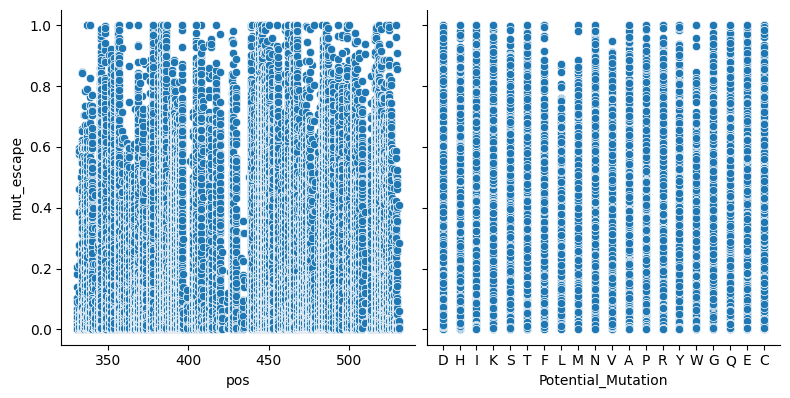

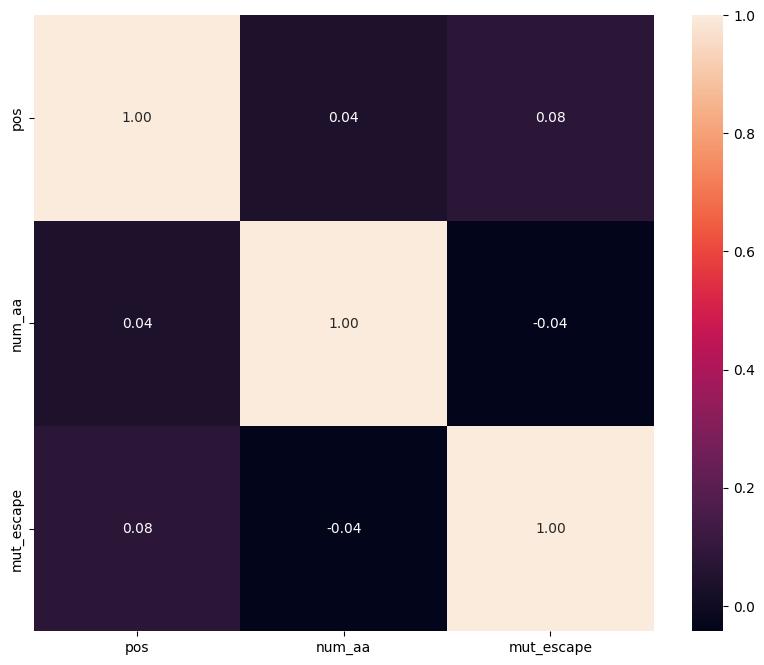

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
print("Packages imported successfully!")

#EDA Code Block
# Load the processed data
output_path = './Processed_Mutation_Data.csv'
final_data = pd.read_csv(output_path)  

# Quick visulization of the relationship between features and target
sns.pairplot(final_data, x_vars=['pos', 'Potential_Mutation'], y_vars='mut_escape', height=4, aspect=1, kind='scatter')
plt.show()

# Filter numeric columns for the correlation heatmap
numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = final_data[numeric_columns]

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f")
plt.show()







Note: you may need to restart the kernel to use updated packages.


c:\Users\truth\OneDrive\Desktop\ml_2\ml_algo_lr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R^2: 0.04
MAE: 0.16
MSE: 0.04
RMSE: 0.21


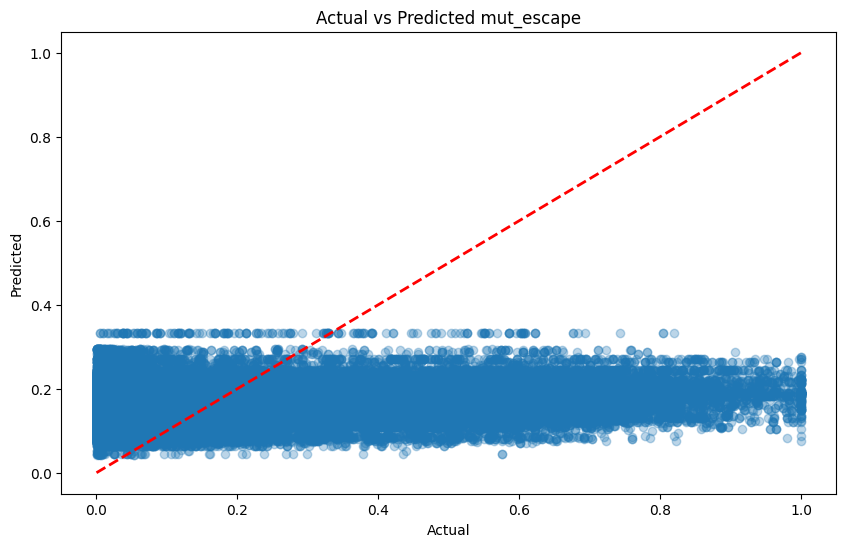

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the processed data
output_path = './Processed_Mutation_Data.csv'
final_data = pd.read_csv(output_path)

# Select the features and target
X = final_data[['pos', 'Potential_Mutation', 'num_aa']]
y = final_data['mut_escape']

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['Potential_Mutation'])
    ],
    remainder='passthrough' # Keep other columns as is
)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R^2: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted mut_escape')
plt.show()

In [4]:
%pip install scikit-learn

  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl (10.6 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get base data path
data_path = os.getenv('DATA_PATH', 'default/path/if/none/set')
output_path = os.getenv('OUTPUT_PATH', 'default/path/if/none/set')
print(f"Data path is set to: {data_path}")

# Load mutation datasets
wuhan_data = pd.read_csv(f'{data_path}/allowed_muts/mut1_SARSCoV2_WuhanHu1_Spike.csv')
ba1_data = pd.read_csv(f'{data_path}/allowed_muts/mut1_BA.1_Omicron_baseline_EPI_ISL_10000028.csv')
ba2_data = pd.read_csv(f'{data_path}/allowed_muts/mut1_BA.2_Omicron_baseline_EPI_ISL_10000005.csv')
ba275_data = pd.read_csv(f'{data_path}/allowed_muts/mut1_BA.2.75_EPI_ISL_13302209.csv')
ba45_data = pd.read_csv(f'{data_path}/allowed_muts/mut1_BA.4_BA.5_EPI_ISL_11207535.csv')
src_neut_data = pd.read_csv(f'{data_path}/src_neut_data.csv')
use_res_clean = pd.read_csv(f'{data_path}/use_res_clean.csv')

# Label each dataset with its variant
datasets = [wuhan_data, ba1_data, ba2_data, ba275_data, ba45_data]
labels = ['Wuhan', 'BA.1', 'BA.2', 'BA.2.75', 'BA.4/BA.5']

for data, label in zip(datasets, labels):
    data['Variant'] = label

# Combine all datasets into one DataFrame
all_variants = pd.concat(datasets, ignore_index=True)

# Explode 'mut1' into separate mutations
all_variants['mut1'] = all_variants['mut1'].apply(list)
all_variants_exploded = all_variants.explode('mut1')
all_variants_exploded.rename(columns={'mut1': 'Potential_Mutation'}, inplace=True)

# Merge with use_res_clean data
final_data = pd.merge(
    all_variants_exploded, use_res_clean,
    left_on=['pos', 'Potential_Mutation'], right_on=['site', 'mutation'],
    how='left'
)

# Clean up the DataFrame to remove unnecessary columns
final_data.drop(['site', 'mutation'], axis=1, inplace=True)

# Save the final DataFrame to a CSV file
final_data.to_csv(f'{output_path}/Processed_Mutation_Data.csv', index=False)
print("Processed data saved successfully.")

# Print some outputs for verification
print("Final Data Head:\n", final_data.head())

# Load all sheets from the Excel file as a dictionary of DataFrames
antibody_info_dict = pd.read_excel(f'{data_path}/antibody_info.xlsx', sheet_name=None)

#Accessing specific sheets
cross_data = antibody_info_dict['cross']
specific_data = antibody_info_dict.get('specific', pd.DataFrame) # Safe access if 'specific' sheet might not exist

# Check the initial few rows of one of the datasets to confirm
print("BA.1 Data Head:\n", ba1_data.head())
print("\nSrc Neutralizing Data Head:\n", src_neut_data.head())
print("\nUse Res Clean Data Head:\n", use_res_clean.head())
print("\nCross Data Head:\n", cross_data.head())
print("\nSpecific Data Head:\n", specific_data.head())

# Identify and print the count of missing values in each column 
print("Missing values before removal:")
print(final_data.isnull().sum()) 

# Drop missing values from the final data
final_data.dropna(inplace=True) 

# Check and print to confirm no more missing values exist
print("Missing values after removal:")
print(final_data.isnull().sum())

# One-hot encode the 'Variant' column
variant_dummies = pd.get_dummies(final_data['Variant'], drop_first=True)

# Join the dummy variables with the og DataFrame
final_data = final_data.join(variant_dummies)

# Drop the original 'Variant' column if no longer needed
# final_data.drop('Variant', axis=1, inplace=True)

# Save the final DataFrame to a CSV file
final_data.to_csv(f'{output_path}/Processed_Mutation_Data.csv', index=False)
print("Processed (one-hot/variant dummies) data saved successfully.")

Data path is set to: C:\Users\truth\OneDrive\Desktop\linear_regression_capstone\convergent_RBD_evolution
Processed data saved successfully.
Final Data Head:
   wt  pos Potential_Mutation  num_aa Variant   antibody  mut_escape group
0  N  331                  D       7   Wuhan  BD55-1104    0.013667    D2
1  N  331                  D       7   Wuhan  BD55-1132    0.017402    F1
2  N  331                  D       7   Wuhan  BD55-1241    0.002578    E3
3  N  331                  D       7   Wuhan  BD55-1345    0.031331    F1
4  N  331                  D       7   Wuhan     BD-778    0.020071    E3
BA.1 Data Head:
   wt  pos     mut1  num_aa Variant
0  N  331  DHIKSTY       7    BA.1
1  I  332  FLMNSTV       7    BA.1
2  T  333   AIKPRS       6    BA.1
3  N  334  DHIKSTY       7    BA.1
4  L  335    FMSVW       5    BA.1

Src Neutralizing Data Head:
   antibody            source D614G_IC50 BA1_IC50 BA2_IC50 BA2_75_IC50 BA5_IC50
0   BD-196  WT convalescents       1.93      >10      >10     